In [13]:
from sogym.env import sogym
import warnings
import dreamerv3
from dreamerv3 import embodied
from dreamerv3 import agent as agt

from embodied.envs import from_gym




In [5]:
from sogym.env import sogym
import warnings
import dreamerv3
from dreamerv3 import embodied
warnings.filterwarnings('ignore', '.*truncated to dtype int32.*')

# See configs.yaml for all options.
config = embodied.Config(dreamerv3.configs['defaults'])
config = config.update(dreamerv3.configs['small'])
config = config.update({
    'run.logdir': './logdir/run1',
    'run.train_ratio': 64,
    'run.log_every': 30,  # Seconds
    'batch_size': 16,
    'encoder.mlp_keys': ['beta','volume','design_variables','n_steps_left','score'],
    'decoder.mlp_keys':  ['beta','volume','design_variables','n_steps_left','score'],
    'encoder.cnn_keys': ['image','structure_strain_energy'],
    'decoder.cnn_keys': ['image','structure_strain_energy'],
    'jax.platform': 'cpu',
    'envs.amount':16,
})

logdir = embodied.Path(config.run.logdir)
step = embodied.Counter()
logger = embodied.Logger(step, [
    embodied.logger.TerminalOutput(),
    embodied.logger.JSONLOutput(logdir, 'metrics.jsonl'),
    embodied.logger.TensorBoardOutput(logdir),
    # embodied.logger.WandBOutput(logdir.name, config),
    # embodied.logger.MLFlowOutput(logdir.name),
])

import crafter
from embodied.envs import from_gym
env = sogym(mode='train',observation_type='topopt_game',vol_constraint_type = 'hard',resolution=50,check_connectivity=True)  # Replace this with your Gym env.
env = from_gym.FromGym(env)

agent = agt.Agent(env.obs_space, env.act_space, step, config)
checkpoint = embodied.Checkpoint()
checkpoint.agent = agent
# checkpoint.load('./logdir/run1/checkpoint.pkl', keys=['agent'])
obs=env._env.reset()
obs=env._obs(obs, 0.0, is_first=True)
obs = {k: embodied.convert(v) for k, v in obs.items()}

act, state = agent.policy(obs, mode='eval')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:10                                                                                   │
│                                                                                                  │
│    7 # See configs.yaml for all options.                                                         │
│    8 config = embodied.Config(dreamerv3.configs['defaults'])                                     │
│    9 config = config.update(dreamerv3.configs['small'])                                          │
│ ❱ 10 config = config.update({                                                                    │
│   11 │   'run.logdir': './logdir/run1',                                                          │
│   12 │   'run.train_ratio': 64,                                                                  │
│   13 │   'run.log_every': 30,  # Seconds                                                         │
│                                                                                                  │
│ /home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/dreamerv3/embodied/core/conf │
│ ig.py:119 in update                                                                              │
│                                                                                                  │
│   116 │     if not keys:                                                                         │
│   117 │   │   raise KeyError(f'Unknown key or pattern {key}.')                                   │
│   118 │     for key in keys:                                                                     │
│ ❱ 119 │   │   old = result[key]                                                                  │
│   120 │   │   try:                                                                               │
│   121 │   │     if isinstance(old, int) and isinstance(new, float):                              │
│   122 │   │   │   if float(int(new)) != new:                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'run.logdir'

In [6]:
driver = embodied.Driver(env)
driver.on_episode(lambda ep, worker: per_episode(ep))
driver.on_step(lambda tran, _: step.increment())
policy = lambda *args: agent.policy(*args, mode='eval')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ ❱ 1 driver = embodied.Driver(env)                                                                │
│   2 driver.on_episode(lambda ep, worker: per_episode(ep))                                        │
│   3 driver.on_step(lambda tran, _: step.increment())                                             │
│   4 policy = lambda *args: agent.policy(*args, mode='eval')                                      │
│                                                                                                  │
│ /Users/thomasrochefort/opt/anaconda3/envs/dreamer/lib/python3.8/site-packages/dreamerv3/embodied │
│ /core/driver.py:18 in __init__                                                                   │
│                                                                                                  │
│   15   }                                                                                         │
│   16                                                                                             │
│   17   def __init__(self, env, **kwargs):                                                        │
│ ❱ 18 │   assert len(env) > 0                                                                     │
│   19 │   self._env = env                                                                         │
│   20 │   self._kwargs = kwargs                                                                   │
│   21 │   self._on_steps = []                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError

In [80]:
driver.reset()
driver._state

In [7]:
env = sogym(nelx=100,nely=50,mode='train',observation_type='dense')  # Replace this with your Gym env.
env = from_gym.FromGym(env)
env._obs

<bound method FromGym._obs of FromGym(len=0, obs_space={'conditions': Space(dtype=float32, shape=(9,), low=-1.0, high=1.0), 'design_variables': Space(dtype=float32, shape=(48,), low=-3.1415927410125732, high=3.1415927410125732), 'n_steps_left': Space(dtype=float32, shape=(1,), low=0.0, high=1.0), 'volume': Space(dtype=float32, shape=(1,), low=0.0, high=1.0), 'reward': Space(dtype=float32, shape=(), low=-inf, high=inf), 'is_first': Space(dtype=bool, shape=(), low=False, high=True), 'is_last': Space(dtype=bool, shape=(), low=False, high=True), 'is_terminal': Space(dtype=bool, shape=(), low=False, high=True)}, act_space={'action': Space(dtype=float32, shape=(6,), low=-1.0, high=1.0), 'reset': Space(dtype=bool, shape=(), low=False, high=True)})>

In [11]:
env._env.reset()


{'conditions': array([ 0.5882353 ,  0.990099  ,  0.        ,  0.        ,  0.98039216,
         0.        ,  0.3       ,  0.57357645, -0.81915206], dtype=float32),
 'design_variables': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'volume': array([0.], dtype=float32),
 'n_steps_left': array([1.], dtype=float32)}

In [12]:
env._env.Phi


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [65]:
obs=env._env.reset()

In [66]:
env._obs(obs, 0.0, is_first=True)

{'conditions': array([ 0.64705884,  0.        ,  0.        ,  0.990099  ,  0.98039216,
         0.990099  ,  0.3       ,  0.57357645, -0.81915206], dtype=float32),
 'design_variables': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'volume': array([0.], dtype=float32),
 'n_steps_left': array([1.], dtype=float32),
 'reward': 0.0,
 'is_first': True,
 'is_last': False,
 'is_terminal': False}

In [6]:
env = sogym(mode='train',observation_type='topopt_game',vol_constraint_type = 'hard',resolution=50,check_connectivity=True)  # Replace this with your Gym env.
env = from_gym.FromGym(env)
env = dreamerv3.wrap_env(env, config)
env = embodied.BatchEnv([env], parallel=False)
driver = embodied.Driver(env)
driver.on_step(lambda tran, _: step.increment())

In [259]:
checkpoint = embodied.Checkpoint()
checkpoint.agent = agent
checkpoint.load('logdir/run1/checkpoint.pkl', keys=['agent'])

print('Start evaluation loop.')
policy = lambda *args: agent.policy(*args, mode='eval')
driver(policy, steps=1)

Loading checkpoint: logdir/run1/checkpoint.pkl
Loading checkpoint with step 11105024
Loaded checkpoint from 371 seconds ago.
Start evaluation loop.
Tracing policy function.
Tracing policy function.


In [328]:
driver.reset()

(5151, 8)


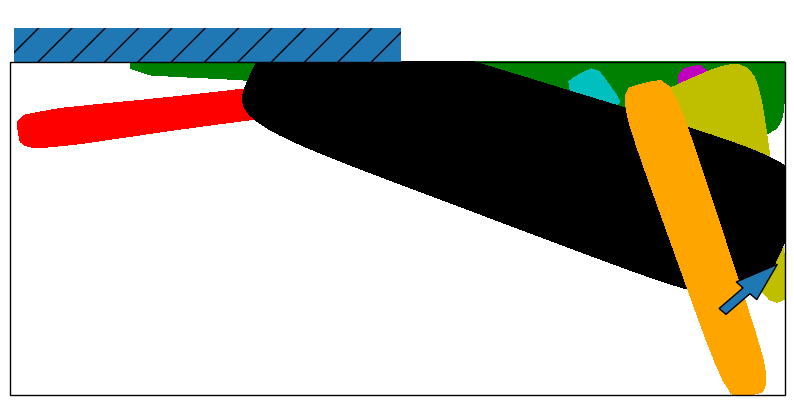

In [337]:
driver(policy, steps=1)
print(driver._env._envs[0]._env.Phi.shape)
driver._env._envs[0]._env.plot(train_viz=False)

In [338]:
print(driver._env._envs[0]._env.compliance)


20.0748340053959


In [7]:
import importlib
import pathlib
import sys
import warnings
from functools import partial as bind
from embodied import wrappers

env = sogym(mode='train',observation_type='topopt_game',vol_constraint_type = 'hard',resolution=50,check_connectivity=True)  # Replace this with your Gym env.
env = from_gym.FromGym(env)
def make_envs(config, **overrides):
  suite, task = config.task.split('_', 1)
  ctors = []
  for index in range(config.envs.amount):
    ctor = lambda: wrap_env(env, config)
    if config.envs.parallel != 'none':
      ctor = bind(embodied.Parallel, ctor, config.envs.parallel)
    if config.envs.restart:
      ctor = bind(wrappers.RestartOnException, ctor)
    ctors.append(ctor)
  envs = [ctor() for ctor in ctors]
  return embodied.BatchEnv(envs, parallel=(config.envs.parallel != 'none'))

In [8]:
def make_replay(
    config, directory=None, is_eval=False, rate_limit=False, **kwargs):
  assert config.replay == 'uniform' or not rate_limit
  length = config.batch_length
  size = config.replay_size // 10 if is_eval else config.replay_size
  if config.replay == 'uniform' or is_eval:
    kw = {'online': config.replay_online}
    if rate_limit and config.run.train_ratio > 0:
      kw['samples_per_insert'] = config.run.train_ratio / config.batch_length
      kw['tolerance'] = 10 * config.batch_size
      kw['min_size'] = config.batch_size
    replay = embodied.replay.Uniform(length, size, directory, **kw)
  elif config.replay == 'reverb':
    replay = embodied.replay.Reverb(length, size, directory)
  elif config.replay == 'chunks':
    replay = embodied.replay.NaiveChunks(length, size, directory)
  else:
    raise NotImplementedError(config.replay)
  return replay




def wrap_env(env, config):
  args = config.wrapper
  for name, space in env.act_space.items():
    if name == 'reset':
      continue
    elif space.discrete:
      env = wrappers.OneHotAction(env, name)
    elif args.discretize:
      env = wrappers.DiscretizeAction(env, name, args.discretize)
    else:
      env = wrappers.NormalizeAction(env, name)
  env = wrappers.ExpandScalars(env)
  if args.length:
    env = wrappers.TimeLimit(env, args.length, args.reset)
  if args.checks:
    env = wrappers.CheckSpaces(env)
  for name, space in env.act_space.items():
    if not space.discrete:
      env = wrappers.ClipAction(env, name)
  return env

In [10]:
config = config.update({
    'logdir': 'logdir/run1',
    'run.train_ratio': 64,
    'run.log_every': 30,  # Seconds
    'batch_size': 16,
    'encoder.mlp_keys': ['conditions','volume','design_variables','n_steps_left'],
    'decoder.mlp_keys':  ['conditions','volume','design_variables','n_steps_left'],
    'encoder.cnn_keys': '$^',
    'decoder.cnn_keys': '$^',
    'jax.platform': 'cpu',
    'envs.amount':16,
})

In [11]:
args = config.run.update(batch_steps=config.batch_size * config.batch_length)

replay = make_replay(config, logdir / 'replay')
env = make_envs(config)
agent = agt.Agent(env.obs_space, env.act_space, step, config)
embodied.run.train(agent, env, replay, logger, args)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 args = config.run.update(batch_steps=config.batch_size * config.batch_length)                │
│   2                                                                                              │
│   3 replay = make_replay(config, logdir / 'replay')                                              │
│   4 env = make_envs(config)                                                                      │
│                                                                                                  │
│ /home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/dreamerv3/embodied/core/conf │
│ ig.py:119 in update                                                                              │
│                                                                                                  │
│   116 │     if not keys:                                                                         │
│   117 │   │   raise KeyError(f'Unknown key or pattern {key}.')                                   │
│   118 │     for key in keys:                                                                     │
│ ❱ 119 │   │   old = result[key]                                                                  │
│   120 │   │   try:                                                                               │
│   121 │   │     if isinstance(old, int) and isinstance(new, float):                              │
│   122 │   │   │   if float(int(new)) != new:                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'batch_steps'